Optional check of timing after each cell

In [1]:
%load_ext autotime

Necessary imports

In [2]:
import os
import re, string
import gzip
from datetime import datetime
import numpy as np
import pandas as pd
import cudf
from pandas import Series, DataFrame
import sklearn.utils
import multiprocessing as mp
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve

time: 923 ms


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib
time: 95.1 ms


/home/rrc/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Set up the DATA_DIR environment variable to point to the review data. Used in all the code.

In [4]:
data_dir = os.environ['DATA_DIR'] + '/'
print(data_dir)

/data/datasets/amazon/
time: 732 µs


Handy function in case you want to see what the asin (amazon item) is.

In [5]:
def amazon_url(item):
    return 'https://www.amazon.com/s?k=' + str(item)

time: 2.75 ms


Load the amazon books reviews. We're interested mainly in the 'reviewtext' and 'overall' (ratings) columns

In [6]:
df = pd.read_csv(data_dir + 'reviews_1_to_5_shuffle.csv', usecols = ['asin', 'reviewText', 'overall']) # reviews_Books_5.csv

time: 10.7 s


Empty values in reviewText turn into "fload" NaN's. Make them empty strings.

In [7]:
df['reviewText'] = df.reviewText.fillna('')

time: 390 ms


Let's have a quick look, see if everything looks ok.

In [8]:
df

,asin,reviewText,overall
0,0446584703,I loved all of Chelsea Handler's other books b...,4.0
1,1494723352,"Drunk on Wonderland, I picked up this book. It...",3.0
2,B00C83F9R6,I have wanted to do kettlebells for quite some...,5.0
3,047146256X,Wow it is sooooo obvious that all thease revie...,1.0
4,1451642865,I picked this book up because I heard Deneen B...,5.0
5,B00H3M921G,"Caleb Donovan, the newest Prophet to the Realm...",5.0
6,1492206083,What a beautiful love story! I loved reading ...,5.0
7,B009YLFHXG,This was a great read.. I loved this book. I c...,4.0
8,0061057568,"I so enjoyed the snappy writing, but by the en...",3.0
9,1595145958,"Pia is immortal,she is cause to exist with the...",2.0


time: 14.5 ms


Split into training and testing.

In [9]:
# Holdout split
split = 0.7
d_train = df[:int(split*len(df))]
d_test = df[int((1-split)*len(df)):]

time: 1.19 ms


Now, building the model with Word2Vec.

This code is adapted from "Real World Machine Learning", by Brink, Richards and Fetherolf
The original code did sentiment analysis of movie reviews, with 0 or 1.
Changes here include
- Changing code to use Python 3
- Reviewing 1 to 5 stars instead of good or bad
- Using parallel techniques to process text where we can since the dataset is much bigger


This is a simple function that, for each review, turns it into a list of tokens.

Since this is basically a map function, we can parallelize it with multiprocessing.

If a list winds up being empty it can mess up functions below, with a list length of 0, so when that happens we insert a neutral word in a list.

In [10]:
stop_words = set(['all', "she'll", "don't", 'being', 'over', 'through', 'yourselves', 'its', 'before', "he's", "when's", "we've", 'had', 'should', "he'd", 'to', 'only', "there's", 'those', 'under', 'ours', 'has', "haven't", 'do', 'them', 'his', "they'll", 'very', "who's", "they'd", 'cannot', "you've", 'they', 'not', 'during', 'yourself', 'him', 'nor', "we'll", 'did', "they've", 'this', 'she', 'each', "won't", 'where', "mustn't", "isn't", "i'll", "why's", 'because', "you'd", 'doing', 'some', 'up', 'are', 'further', 'ourselves', 'out', 'what', 'for', 'while', "wasn't", 'does', "shouldn't", 'above', 'between', 'be', 'we', 'who', "you're", 'were', 'here', 'hers', "aren't", 'by', 'both', 'about', 'would', 'of', 'could', 'against', "i'd", "weren't", "i'm", 'or', "can't", 'own', 'into', 'whom', 'down', "hadn't", "couldn't", 'your', "doesn't", 'from', "how's", 'her', 'their', "it's", 'there', 'been', 'why', 'few', 'too', 'themselves', 'was', 'until', 'more', 'himself', "where's", "i've", 'with', "didn't", "what's", 'but', 'herself', 'than', "here's", 'he', 'me', "they're", 'myself', 'these', "hasn't", 'below', 'ought', 'theirs', 'my', "wouldn't", "we'd", 'and', 'then', 'is', 'am', 'it', 'an', 'as', 'itself', 'at', 'have', 'in', 'any', 'if', 'again', 'no', 'that', 'when', 'same', 'how', 'other', 'which', 'you', "shan't", 'our', 'after', "let's", 'most', 'such', 'on', "he'll", 'a', 'off', 'i', "she'd", 'yours', "you'll", 'so', "we're", "she's", 'the', "that's", 'having', 'once'])

def tokenize_one(d):
    pattern = re.compile('[\W_]+', re.UNICODE)
    sentence = d.lower().split(" ") 
    sentence = [pattern.sub('', w) for w in sentence]
    result = [w for w in sentence if w not in stop_words]
    # Some sentences are empty, putting NaNs in features, which is bad
    return ['read'] if len(result) == 0 else result

def tokenize(docs):
    pool = mp.Pool(mp.cpu_count())
    sentences = pool.map(tokenize_one, [d for d in docs])
    pool.close()
    
    return sentences

time: 3.79 ms


In [11]:
sentences = tokenize(d_train['reviewText'])

time: 35.2 s


Build the Word2Vec model, with as many cpu's as you can for workers

In [12]:
model = Word2Vec(sentences, size=300, window=10, min_count=1, sample=1e-3, workers=mp.cpu_count())

time: 7min 26s


Save the model for later serving

In [13]:
model.init_sims(replace=True)

time: 11.8 s


In [14]:
model.save(data_dir + 'word2vec.model')

/home/rrc/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


time: 9.21 s


Generate feature vectors. Average vector of all the words in the document.

In [15]:
def featurize_w2v(model, sentences):
    f = np.zeros((len(sentences), model.vector_size))
    for i,s in enumerate(sentences):
        for w in s:
            try:
                vec = model[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        f[i,:] = f[i,:] / len(s)
    return f

time: 1.03 ms


In [16]:
features_w2v = featurize_w2v(model, sentences)

/home/rrc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


time: 8min 40s


The feature vectors are numpy arrays, let's save them out in case we want to build a model quickly.

In [17]:
np.save(data_dir + 'fw', features_w2v)

time: 3.84 s


Run a RandomForestClassifier on the features and the training data

In [18]:
forest_model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest_model.fit(features_w2v, d_train.overall)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

time: 10min 16s


Save so it can be loaded to serve review predictions.

In [19]:
joblib.dump(forest_model, data_dir + 'forest_model.sav')

['/data/datasets/amazon/forest_model.sav']

time: 39 s


Test the model.

Re-index the test data so they line up in comparisons.

In [20]:
d_test = d_test.reset_index(drop=True)

time: 187 ms


Tokenize and featurize the test data.

In [21]:
test_sentences = tokenize(d_test.reviewText)

time: 35.9 s


In [22]:
test_features_w2v = featurize_w2v(model, test_sentences)

/home/rrc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


time: 8min 44s


Make predictions!

In [23]:
predictions = forest_model.predict_proba(test_features_w2v)

time: 21.7 s


In [24]:
predictions

array([[0.67, 0.1 , 0.07, 0.08, 0.08],
       [0.07, 0.79, 0.09, 0.04, 0.01],
       [0.01, 0.03, 0.09, 0.84, 0.03],
       ...,
       [0.12, 0.3 , 0.28, 0.2 , 0.1 ],
       [0.16, 0.15, 0.28, 0.23, 0.18],
       [0.08, 0.23, 0.32, 0.2 , 0.17]])

time: 1.95 ms


In [25]:
d_test.overall

0          1.0
1          2.0
2          4.0
3          3.0
4          5.0
5          1.0
6          1.0
7          2.0
8          1.0
9          2.0
10         4.0
11         1.0
12         2.0
13         2.0
14         2.0
15         1.0
16         2.0
17         3.0
18         2.0
19         1.0
20         2.0
21         5.0
22         1.0
23         4.0
24         4.0
25         3.0
26         3.0
27         4.0
28         3.0
29         4.0
          ... 
1133386    2.0
1133387    1.0
1133388    1.0
1133389    2.0
1133390    2.0
1133391    5.0
1133392    5.0
1133393    2.0
1133394    2.0
1133395    1.0
1133396    1.0
1133397    1.0
1133398    2.0
1133399    2.0
1133400    1.0
1133401    1.0
1133402    2.0
1133403    4.0
1133404    3.0
1133405    3.0
1133406    5.0
1133407    1.0
1133408    1.0
1133409    1.0
1133410    1.0
1133411    3.0
1133412    2.0
1133413    3.0
1133414    1.0
1133415    3.0
Name: overall, Length: 1133416, dtype: float64

time: 14.3 ms


Do a check in the middle of the data.

In [26]:
for index in range(50000, 50200):
    print("{}, {}, {}".format(d_test.overall[index], np.argmax(predictions[index]) + 1, predictions[index]))

2.0, 2, [0.06 0.79 0.07 0.05 0.03]
4.0, 4, [0.02 0.01 0.03 0.77 0.17]
2.0, 2, [0.09 0.78 0.07 0.05 0.01]
5.0, 5, [0.08 0.11 0.06 0.06 0.69]
5.0, 5, [0.18 0.07 0.04 0.02 0.69]
2.0, 2, [0.13 0.71 0.05 0.03 0.08]
4.0, 4, [0.13 0.04 0.02 0.78 0.03]
3.0, 3, [0.05 0.03 0.75 0.13 0.04]
5.0, 5, [0.05 0.03 0.1  0.03 0.79]
3.0, 3, [0.06 0.09 0.75 0.06 0.04]
3.0, 3, [0.02 0.06 0.68 0.07 0.17]
5.0, 5, [0.01 0.01 0.03 0.1  0.85]
3.0, 3, [0.04 0.11 0.76 0.07 0.02]
4.0, 4, [0.02 0.   0.02 0.78 0.18]
2.0, 2, [0.09 0.75 0.1  0.02 0.04]
1.0, 1, [0.88 0.1  0.02 0.   0.  ]
5.0, 5, [0.01 0.01 0.03 0.04 0.91]
2.0, 2, [0.05 0.69 0.1  0.1  0.06]
1.0, 1, [0.81 0.12 0.05 0.01 0.01]
5.0, 5, [0.   0.01 0.07 0.12 0.8 ]
4.0, 4, [0.06 0.05 0.08 0.77 0.04]
1.0, 1, [0.75 0.07 0.06 0.03 0.09]
5.0, 5, [0.05 0.02 0.   0.02 0.91]
1.0, 1, [0.84 0.11 0.04 0.   0.01]
2.0, 2, [0.14 0.71 0.09 0.05 0.01]
2.0, 2, [0.02 0.72 0.14 0.08 0.04]
2.0, 2, [0.04 0.77 0.09 0.08 0.02]
3.0, 3, [0.01 0.03 0.76 0.17 0.03]
5.0, 5, [0.09 0.09 0

Other checks, graphs.

In [27]:
def performance(y_true, pred, index, color="g", ann=True):
    acc = accuracy_score(y_true, pred[:,index] > 0.5)
    auc = roc_auc_score(y_true, pred[:,index])
    fpr, tpr, thr = roc_curve(y_true, pred[:,index])
    plot(fpr, tpr, color, linewidth="3")
    xlabel("False positive rate")
    ylabel("True positive rate")
    if ann:
        annotate("Acc: %0.2f" % acc, (0.1,0.8), size=14)
        annotate("AUC: %0.2f" % auc, (0.1,0.7), size=14)

time: 1.09 ms


(0, 0.3)

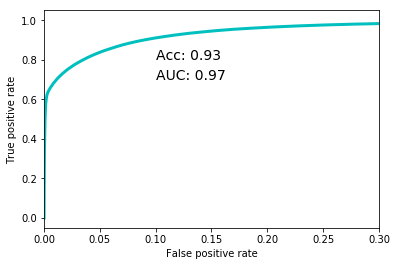

time: 591 ms


In [28]:
performance(d_test.overall == 1.0, predictions, 0, color="c")
xlim(0,0.3)

(0, 0.3)

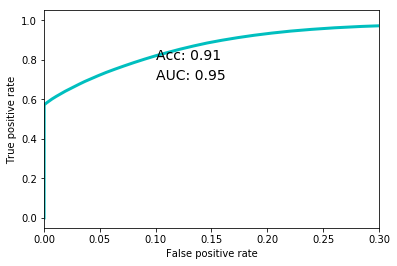

time: 543 ms


In [29]:
performance(d_test.overall == 2.0, predictions, 1, color="c")
xlim(0,0.3)

(0, 0.3)

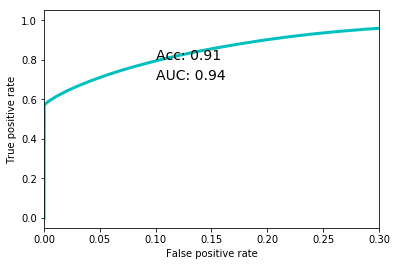

time: 536 ms


In [30]:
performance(d_test.overall == 3.0, predictions, 2, color="c")
xlim(0,0.3)

(0, 0.3)

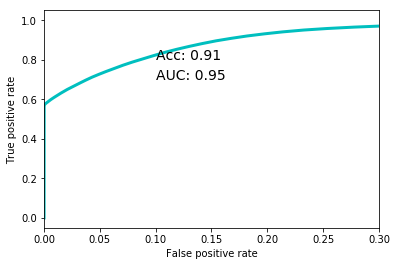

time: 547 ms


In [31]:
performance(d_test.overall == 4.0, predictions, 3, color="c")
xlim(0,0.3)

(0, 0.3)

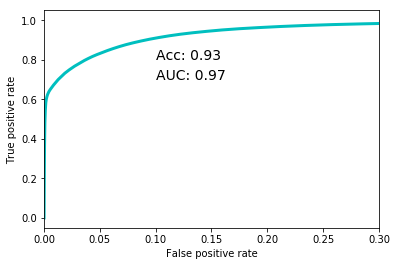

time: 552 ms


In [32]:
performance(d_test.overall == 5.0, predictions, 4, color="c")
xlim(0,0.3)